In [1]:
!pip install xgboost




In [2]:
# Import Libraries

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Time Series & Statistical Modeling 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import holidays

#Scikit-Learn for Feature Engineering & Classic ML ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import math

#Advanced Modeling Libraries ---
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set global plotting styles
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#333333",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "figure.figsize": (14,5)
})

RND = 42
np.random.seed(RND)


In [3]:
#  Data Loading and Preprocessing
# Handles type conversion, sets the time-series index, and imputes missing values using forward-fill 
# and rolling median to maintain continuity and avoid lookahead bias.

# Load and prepare data
df = pd.read_csv("dataset.csv")

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'], format="%d-%m-%Y")

#  Clean consumption column 
if "consumption_kWh" not in df.columns:
    raise KeyError("Missing required column: 'consumption_kWh' in CSV.")

# Remove commas, strip spaces, and convert to float
df['consumption_kWh'] = (
    df['consumption_kWh']
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
    .astype(float)
)

# Create initial derived features
df['day_of_week'] = df['datetime'].dt.day_name()
df['week_number'] = df['datetime'].dt.isocalendar().week.astype(int)

# Holidays in Uganda
ug_holidays = holidays.UG(years=df['datetime'].dt.year.unique())
df['is_holiday'] = df['datetime'].dt.date.apply(lambda d: 1 if d in ug_holidays else 0)

#  Validate and prepare time index ---
df = df.sort_values("datetime").drop_duplicates(subset=["datetime"]).reset_index(drop=True)
df.set_index("datetime", inplace=True)

# Fill missing dates to ensure continuity (daily frequency)
freq = "D"
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
df = df.reindex(full_idx)
df.index.name = "datetime"

#  Handle missing consumption values if any using forward-fill and rolling median 
df['consumption_kWh'] = df['consumption_kWh'].ffill(limit=3)
df['consumption_kWh'] = df['consumption_kWh'].fillna(
    df['consumption_kWh'].rolling(7, min_periods=1).median()
)

#  Recompute derived features 
df['day_of_week'] = df.index.day_name()
df['week_number'] = df.index.isocalendar().week.astype(int)
df['month'] = df.index.month_name()

#  Recompute holidays if any missing
if 'is_holiday' not in df.columns or df['is_holiday'].isnull().any():
    ug_holidays = holidays.UG(years=df.index.year.unique())
    df['is_holiday'] = df.index.date
    df['is_holiday'] = df['is_holiday'].apply(lambda d: 1 if d in ug_holidays else 0)

# Summary of data preparation
print("Data span:", df.index.min().date(), "→", df.index.max().date())
print("Missing consumption values:", df['consumption_kWh'].isna().sum())

df.head()


Data span: 2021-01-01 → 2025-11-13
Missing consumption values: 0


,consumption_kWh,day_of_week,week_number,is_holiday,month
datetime,,,,,
2021-01-01,26371.61,Friday,53,1,January
2021-01-02,23079.92,Saturday,53,0,January
2021-01-03,24218.42,Sunday,53,0,January
2021-01-04,20242.38,Monday,1,0,January
2021-01-05,20116.16,Tuesday,1,0,January


In [4]:
#check for data_types
df.dtypes

consumption_kWh    float64
day_of_week         object
week_number          int64
is_holiday           int64
month               object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1778 entries, 2021-01-01 to 2025-11-13
Freq: D
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   consumption_kWh  1778 non-null   float64
 1   day_of_week      1778 non-null   object 
 2   week_number      1778 non-null   int64  
 3   is_holiday       1778 non-null   int64  
 4   month            1778 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 83.3+ KB


In [6]:
#check for null values
df.isnull().sum()

consumption_kWh    0
day_of_week        0
week_number        0
is_holiday         0
month              0
dtype: int64

In [7]:
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


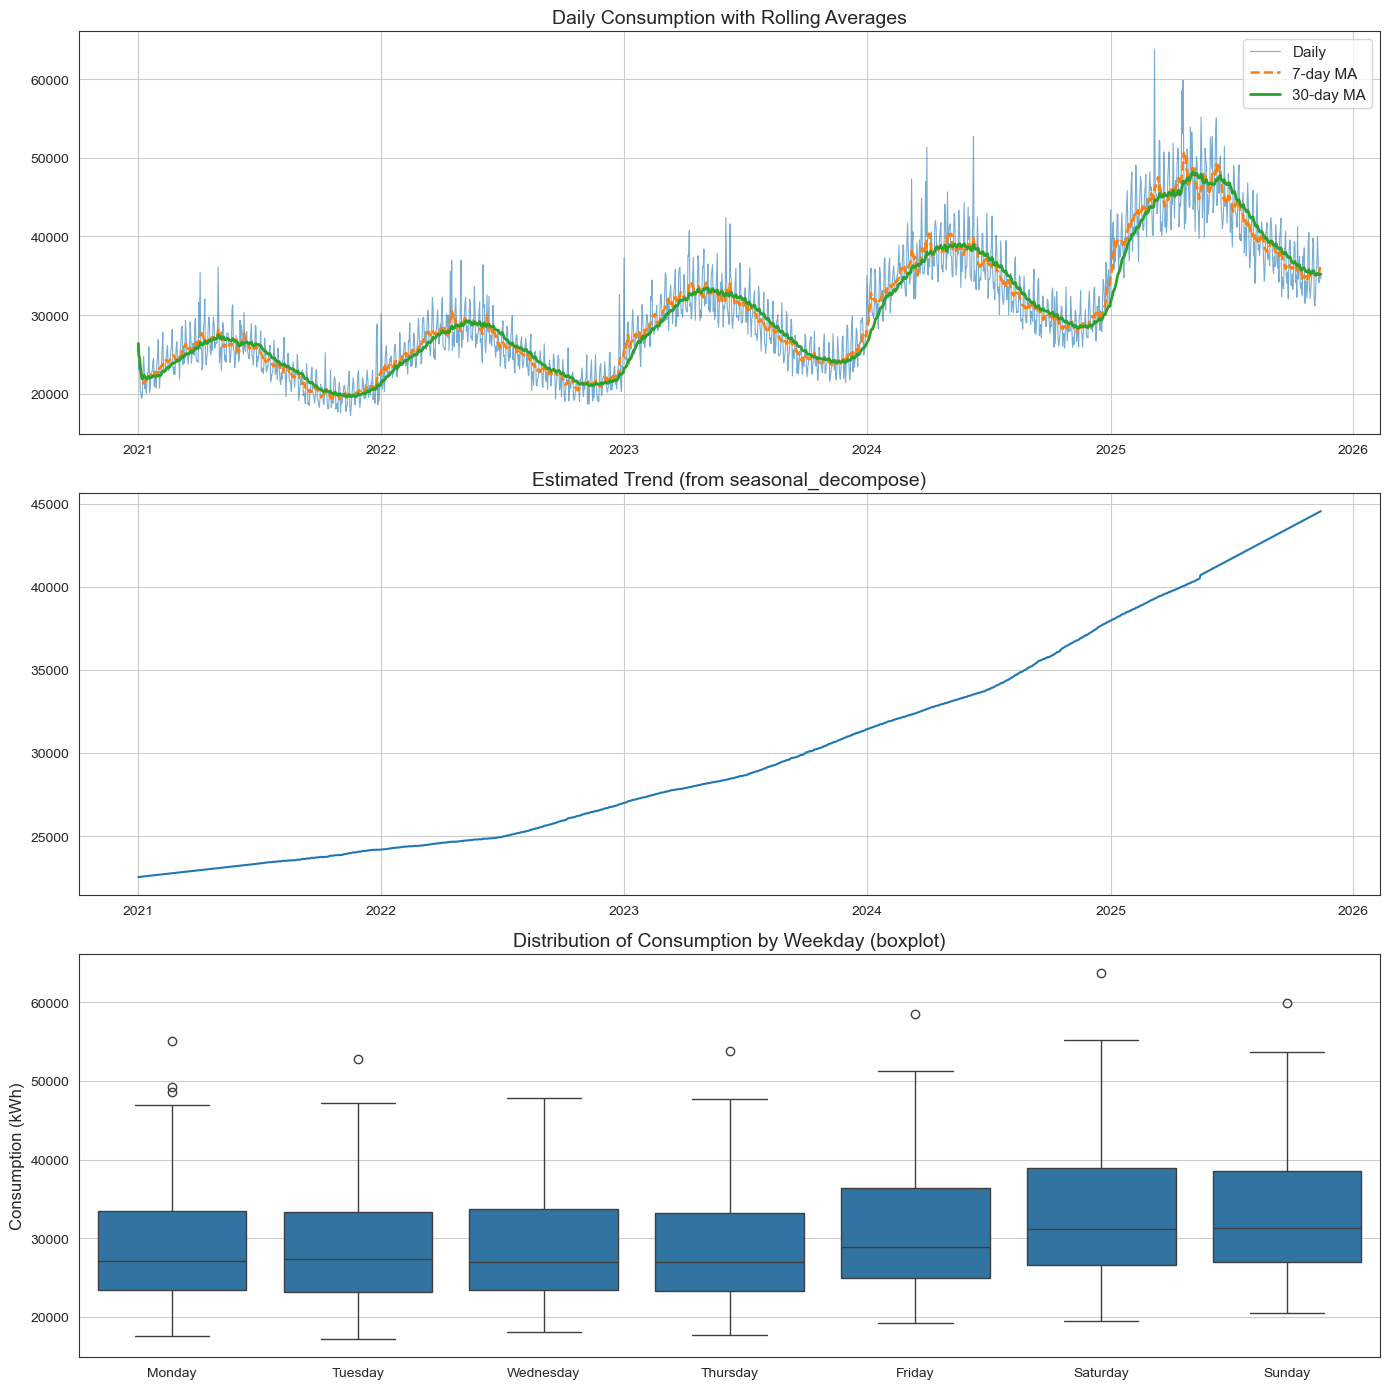

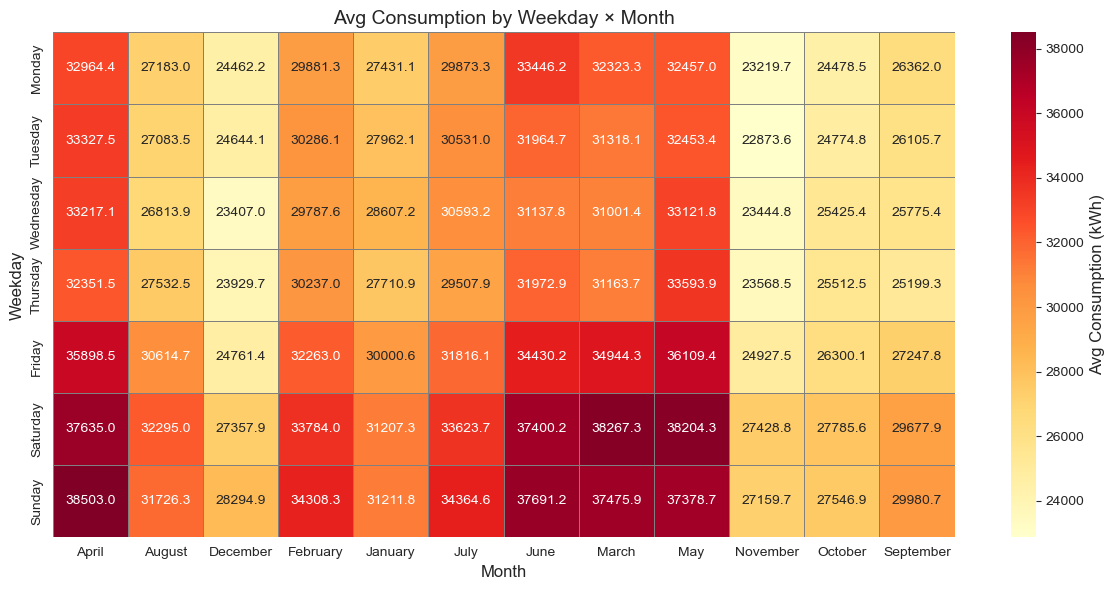

In [8]:
# ###  Exploratory Data Analysis (EDA)
# Visualizes time series patterns through three complementary perspectives:
# 1) Rolling averages (7-day and 30-day) to smooth short-term volatility and highlight trends.
# 2) Annual trend extraction via seasonal_decompose (only if >=1 year of data), providing a clear view of long-term movement.
# 3) Weekday-wise distribution using a boxplot to expose intra-week seasonal patterns and variability.
# 4) Heatmap of average consumption by weekday and month to visualize seasonal patterns.
# Together, these plots diagnose trend, seasonality, and daily variability in consumption, guiding feature engineering and model selection.

# Rolling means
df['rolling_7'] = df['consumption_kWh'].rolling(7, min_periods=1).mean()
df['rolling_30'] = df['consumption_kWh'].rolling(30, min_periods=1).mean()

fig, axes = plt.subplots(3, 1, figsize=(14, 14))  

# 1) Rolling averages
axes[0].plot(df.index, df['consumption_kWh'], lw=0.8, alpha=0.6, label='Daily')
axes[0].plot(df.index, df['rolling_7'], lw=1.8, label='7-day MA', linestyle='--')
axes[0].plot(df.index, df['rolling_30'], lw=2.0, label='30-day MA', linestyle='-')
axes[0].set_title("Daily Consumption with Rolling Averages")
axes[0].legend()

# 2) Seasonal decomposition yearly trend
if len(df) >= 365:
    decomp = seasonal_decompose(df['consumption_kWh'], period=365, model='additive', extrapolate_trend='freq')
    axes[1].plot(decomp.trend, label='Trend')
    axes[1].set_title("Estimated Trend (from seasonal_decompose)")
else:
    axes[1].text(0.5, 0.5, "Insufficient data for annual decomposition (~1 year needed).",
                 ha='center', va='center', fontsize=12)
    axes[1].set_axis_off()

# 3) Boxplot by weekday 
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.boxplot(
    data=df.reset_index(),
    x='day_of_week',
    y='consumption_kWh',
    order=order,
    ax=axes[2]
)
axes[2].set_title("Distribution of Consumption by Weekday (boxplot)")
axes[2].set_xlabel("")
axes[2].set_ylabel("Consumption (kWh)")

plt.tight_layout()
plt.show()


#  4) Heatmap ---
df_h = df.copy()
df_h['Month'] = df_h.index.month_name()
df_h['Weekday'] = df_h.index.day_name()

heat = df_h.pivot_table(
    index='Weekday',
    columns='Month',
    values='consumption_kWh',
    aggfunc='mean'
)

heat = heat.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.figure(figsize=(12,6))
sns.heatmap(heat, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5, linecolor='gray',
            cbar_kws={'label':'Avg Consumption (kWh)'})
plt.title("Avg Consumption by Weekday × Month")
plt.tight_layout()
plt.show()


In [9]:
# Converts the raw time series into a supervised learning dataset for ML models:
# Lag features capture recent history to allow models to learn temporal dependencies.
# Rolling mean and std features summarize local trends and volatility.
# Calendar-based features (day of week, month, weekend) encode deterministic seasonal patterns.
# Optional holiday flags integrate domain knowledge without introducing NaNs.
# Drops rows where lag/rolling features are undefined to maintain clean training data.
# This engineered feature set enables standard ML models (XGBoost, Random Forest, etc.) to operate effectively on temporal data.


def make_lag_features(df, target_col='consumption_kWh', lags=[1,2,3,7,14,30]):
    df_feat = df.sort_index().copy()
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
    return df_feat

def make_rolling_features(df, window_sizes=[7,14,30]):
    df_feat = df.sort_index().copy()
    for w in window_sizes:
        df_feat[f'roll_mean_{w}'] = df_feat['consumption_kWh'].shift(1).rolling(w, min_periods=1).mean()
        df_feat[f'roll_std_{w}']  = df_feat['consumption_kWh'].shift(1).rolling(w, min_periods=1).std()
    return df_feat

# Apply feature generators
df_feat = make_lag_features(df, lags=[1,2,3,7,14,30])
df_feat = make_rolling_features(df_feat, window_sizes=[7,14,30])

# Calendar features
df_feat['dayofweek_num'] = df_feat.index.dayofweek
df_feat['is_weekend'] = df_feat['dayofweek_num'].isin([5,6]).astype(int)
df_feat['month_num'] = df_feat.index.month

# Holiday feature (if not already present)
if 'is_holiday' not in df_feat.columns:
    df_feat['is_holiday'] = 0
df_feat['is_holiday'] = df_feat['is_holiday'].fillna(0).astype(int)

# Drop rows with missing lag/rolling values
lag_roll_cols = [c for c in df_feat.columns if c.startswith('lag_') or c.startswith('roll_')]
df_feat = df_feat.dropna(subset=lag_roll_cols)

# Final feature frame ready for ML models
print("Feature frame:", df_feat.shape)
df_feat.head()


Feature frame: (1748, 22)


,consumption_kWh,day_of_week,week_number,is_holiday,month,rolling_7,rolling_30,lag_1,lag_2,lag_3,...,lag_30,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_30,roll_std_30,dayofweek_num,is_weekend,month_num
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-31,26867.15,Sunday,4,0,January,22986.354286,22321.371667,24656.45,23633.29,20713.24,...,26371.61,22640.338571,1615.516977,22660.486429,1738.409750,22304.853667,1890.715297,6,1,1
2021-02-01,23347.96,Monday,5,0,February,23332.245714,22330.306333,26867.15,24656.45,23633.29,...,23079.92,22986.354286,2214.733622,22725.715000,1882.642156,22321.371667,1929.241240,0,0,2
2021-02-02,20691.48,Tuesday,5,0,February,23149.384286,22212.741667,23347.96,26867.15,24656.45,...,24218.42,23332.245714,2019.960777,22953.724286,1734.968055,22330.306333,1933.491342,1,0,2
2021-02-03,22820.29,Wednesday,5,0,February,23247.122857,22298.672000,20691.48,23347.96,26867.15,...,20242.38,23149.384286,2212.442956,22962.501429,1722.237740,22212.741667,1921.919024,2,0,2
2021-02-04,22233.96,Thursday,5,0,February,23464.368571,22369.265333,22820.29,20691.48,23347.96,...,20116.16,23247.122857,2175.015392,22980.078571,1719.223109,22298.672000,1888.117823,3,0,2


In [10]:
# Prepares dataset for supervised learning with time-aware split:
# 1) Splits data using last 90 days as holdout to prevent leakage.
# 2) Defines feature and target columns, including lag, rolling, and calendar features.
# 3) Validates all required columns exist.
# 4) Applies StandardScaler to features (fit on train, transform both sets).
# 5) Converts target to float arrays and outputs basic diagnostics (date ranges, shapes).
# Ensures a clean, reproducible, ML-ready dataset.


TEST_DAYS = 90  # use multiple of 7 if weekly seasonality matters

# Ensure chronological order and consistent index
df_feat = df_feat.sort_index()
total_days = len(df_feat)
if TEST_DAYS >= total_days:
    raise ValueError(f"TEST_DAYS={TEST_DAYS} >= dataset length ({total_days}). Reduce TEST_DAYS.")

# Split by N days from the end
train = df_feat.iloc[:-TEST_DAYS].copy()
test  = df_feat.iloc[-TEST_DAYS:].copy()

# Define features and target columns
FEATURES = [
    'lag_1','lag_2','lag_3','lag_7','lag_14','lag_30',
    'roll_mean_7','roll_std_7','roll_mean_14','roll_std_14','roll_mean_30','roll_std_30',
    'dayofweek_num','month_num','is_weekend','is_holiday'
]
TARGET = 'consumption_kWh'

# Validate required columns exist
missing = [f for f in FEATURES + [TARGET] if f not in df_feat.columns]
if missing:
    raise KeyError(f"Missing expected columns in df_feat: {missing}")

# Scale features for models that need it (linear, LSTM, NN)
scaler = StandardScaler()
X_train = scaler.fit_transform(train[FEATURES])
X_test  = scaler.transform(test[FEATURES])

y_train = train[TARGET].to_numpy(dtype=float)
y_test  = test[TARGET].to_numpy(dtype=float)

# Diagnostics
print(f"Train window: {train.index.min().date()} → {train.index.max().date()}")
print(f"Test  window: {test.index.min().date()} → {test.index.max().date()}")
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")


Train window: 2021-01-31 → 2025-08-15
Test  window: 2025-08-16 → 2025-11-13
Train shape: (1658, 16) | Test shape: (90, 16)



Model performance (last 90 days):
                      rmse       mae
Naive             3254.618  2490.754
LinearRegression  1609.021  1348.526
RandomForest      1954.850  1518.774



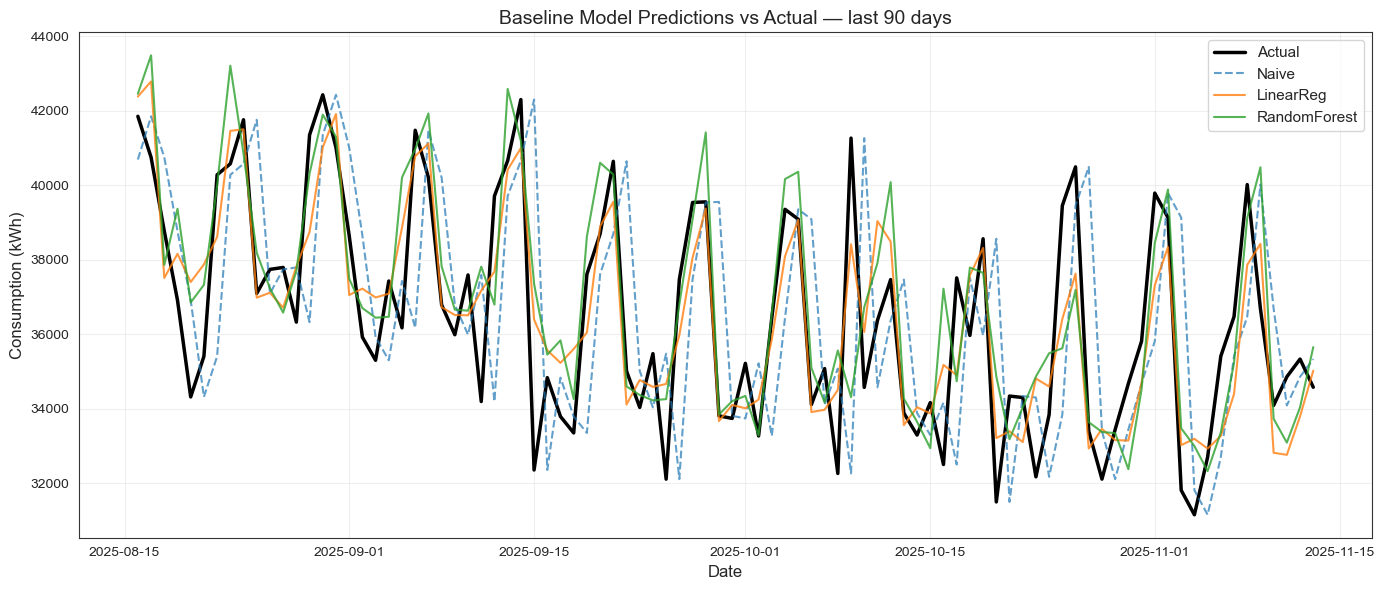

In [11]:
# Establishes baseline forecasts with increasing model complexity:
# 1) Naive: predicts last observed value (lag_1) as a benchmark.
# 2) Linear Regression: captures linear relationships in engineered features.
# 3) Random Forest: models non-linear interactions without scaling.
# For each model, predictions are made on the holdout, RMSE and MAE computed, and results consolidated.
# Plots compare actual vs predicted values for trend and volatility assessment, providing reference points for advanced models.


#  Computes RMSE and MAE between true and predicted values 
def evaluate(y_true, y_pred, prefix=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    return pd.Series({"rmse": rmse, "mae": mae}, name=prefix)

#  Baseline 1: Naive (last observed value) 
naive_preds = test['lag_1'].to_numpy()
naive_scores = evaluate(y_test, naive_preds, prefix="Naive")

#  Baseline 2: Linear Regression  (with feature scaling)
lr = LinearRegression(n_jobs=-1) # use all CPU cores for faster training
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_scores = evaluate(y_test, lr_preds, prefix="LinearRegression")

#  Baseline 3: Random Forest 
rf = RandomForestRegressor(
    n_estimators=200, # number of trees
    random_state=RND,
    n_jobs=-1,
    min_samples_split=2, # min samples to split
    min_samples_leaf=1, # min samples per leaf
)
rf.fit(train[FEATURES], y_train)
rf_preds = rf.predict(test[FEATURES])
rf_scores = evaluate(y_test, rf_preds, prefix="RandomForest")

# Consolidate results
results = pd.concat([naive_scores, lr_scores, rf_scores], axis=1).T
print("\nModel performance (last {} days):".format(TEST_DAYS))
print(results.round(3))
print()

#  Visualization 
plt.figure(figsize=(14, 6))
plt.plot(test.index, y_test, label="Actual", linewidth=2.5, color="black")
plt.plot(test.index, naive_preds, label="Naive", linestyle="--", alpha=0.7)
plt.plot(test.index, lr_preds, label="LinearReg", alpha=0.8)
plt.plot(test.index, rf_preds, label="RandomForest", alpha=0.8)
plt.title(f"Baseline Model Predictions vs Actual — last {TEST_DAYS} days")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0268      0.026     -1.026      0.305      -0.078       0.024
ar.L2          0.0010      0.024      0.042      0.967      -0.045       0.047
ma.L1         -0.8351      0.018    -47.173      0.000      -0.870      -0.800
ar.S.L7        0.9968      0.003    336.942      0.000       0.991       1.003
ma.S.L7       -0.8815      0.013    -67.375      0.000      -0.907      -0.856
sigma2      3.751e+06   6.26e+04     59.930      0.000    3.63e+06    3.87e+06

SARIMAX performance:
rmse    1879.074
mae     1517.172
Name: SARIMAX, dtype: float64


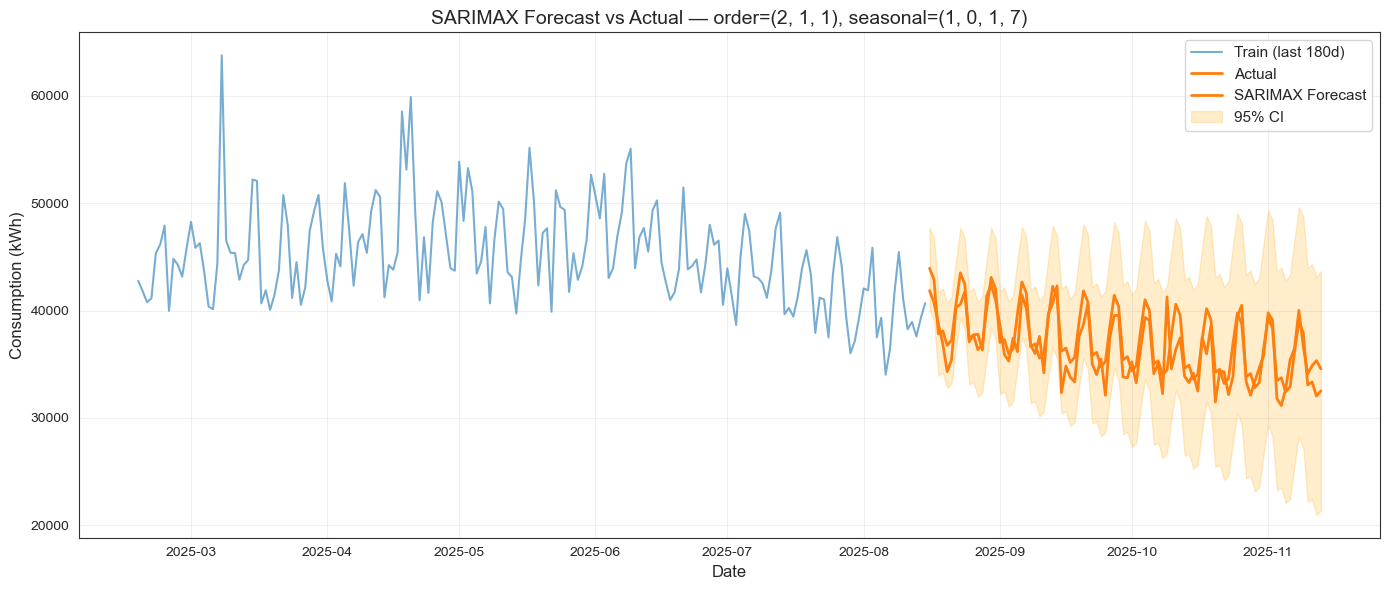

In [12]:
# Fit SARIMAX to capture trend and weekly seasonality in daily data
# Set (p,d,q) and seasonal (P,D,Q,s) for short-term autocorrelation and 7-day cycles
# Train model on data, allowing non-stationary and non-invertible patterns
# Forecast TEST_DAYS ahead with confidence intervals
# Evaluate performance using RMSE and MAE
# Plot recent training data, test data, and forecast with 95% CI
# Acts as a baseline against ML and deep learning models



#  Model configuration 
sar_order = (2, 1, 1)          # (p,d,q):AR2 for short-term memory, 1 difference for trend, |Moving Avg|1 for recent errors 
seasonal_order = (1, 0, 1, 7)  # (P,D,Q,s): seasonal AR1 + seasonal MA1 to capture weekly (7-day) pattern, no seasonal differencing

# Fit model
sarima_model = sm.tsa.statespace.SARIMAX(
    train[TARGET],
    order=sar_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_res = sarima_model.fit(disp=False)
print(sarima_res.summary().tables[1])

# Forecast forward by TEST_DAYS
sarima_fore = sarima_res.get_forecast(steps=TEST_DAYS)
sarima_pred = sarima_fore.predicted_mean
sarima_ci = sarima_fore.conf_int()

# Align forecast index to test period
sarima_pred.index = test.index
sarima_ci.index = test.index

# Evaluate accuracy
sarima_scores = evaluate(y_test, sarima_pred.values, prefix="SARIMAX")
print("\nSARIMAX performance:")
print(sarima_scores.round(3))

# Plot with confidence interval
plt.figure(figsize=(14, 6))
plt.plot(train.index[-180:], train[TARGET].iloc[-180:], label="Train (last 180d)", alpha=0.6)
plt.plot(test.index, y_test, label="Actual", linewidth=2)
plt.plot(test.index, sarima_pred, label="SARIMAX Forecast", color="tab:orange", linewidth=2)
plt.fill_between(
    test.index,
    sarima_ci.iloc[:, 0],
    sarima_ci.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="95% CI"
)
plt.title(f"SARIMAX Forecast vs Actual — order={sar_order}, seasonal={seasonal_order}")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



XGBoost performance:
rmse    1944.944
mae     1574.789
Name: XGBoost, dtype: float64


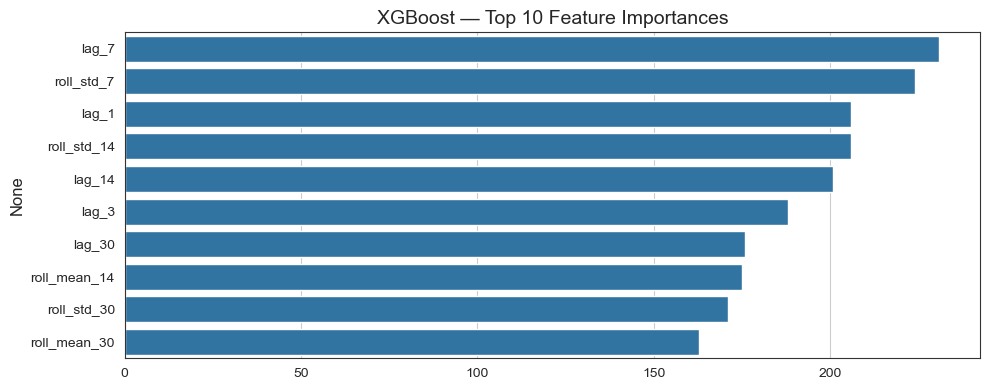

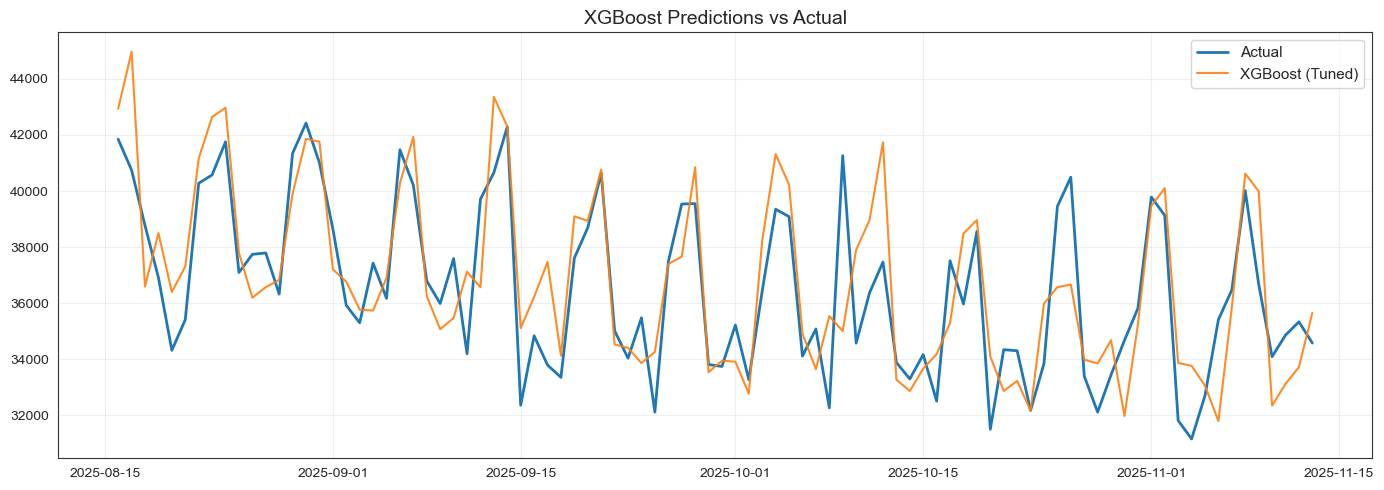

In [13]:
# XGBoost regression with pre-tuned hyperparameters
# Capture non-linear feature interactions via gradient boosting
# Apply early stopping to prevent overfitting and find optimal boosting rounds
# Predict on test set and evaluate performance
# Plot top 10 feature importances and predictions vs actuals




# Prepare XGBoost’s optimized data structure (DMatrix)
VALID_DAYS = max(30, int(len(train) * 0.1))
X_tr = train[FEATURES].iloc[:-VALID_DAYS]
y_tr = train[TARGET].iloc[:-VALID_DAYS]
X_val = train[FEATURES].iloc[-VALID_DAYS:]
y_val = train[TARGET].iloc[-VALID_DAYS:]

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(test[FEATURES])


# Apply manually tuned hyperparameters from previous Optuna search in another Notebook
# Skip hyperparameter optimization to save time
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.20564128334631623,
    "max_depth": 9,
    "min_child_weight": 16.30348674589026,
    "subsample": 0.7656717593192375,
    "colsample_bytree": 0.5251253259307362,
    "gamma": 9.390116350603892,
    "seed": RND,
    "nthread": -1,
}

evals = [(dtrain, "train"), (dvalid, "valid")]

# Train with early stopping (using manually tuned params)
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Predict on test set
xgb_preds = xgb_model.predict(dtest)
xgb_scores = evaluate(y_test, xgb_preds, prefix="XGBoost")
print("\nXGBoost performance:")
print(xgb_scores.round(3))

# Feature importance (top 10) 
importance = xgb_model.get_score(importance_type="weight")
feat_imp = (
    pd.Series(importance)
    .reindex(FEATURES)
    .fillna(0)
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("XGBoost — Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# Predictions vs actual 
plt.figure(figsize=(14, 5))
plt.plot(test.index, y_test, label="Actual", linewidth=2)
plt.plot(test.index, xgb_preds, label="XGBoost (Tuned)", alpha=0.9)
plt.title("XGBoost Predictions vs Actual")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

LSTM performance: rmse    1914.456
mae     1604.619
Name: LSTM, dtype: float64


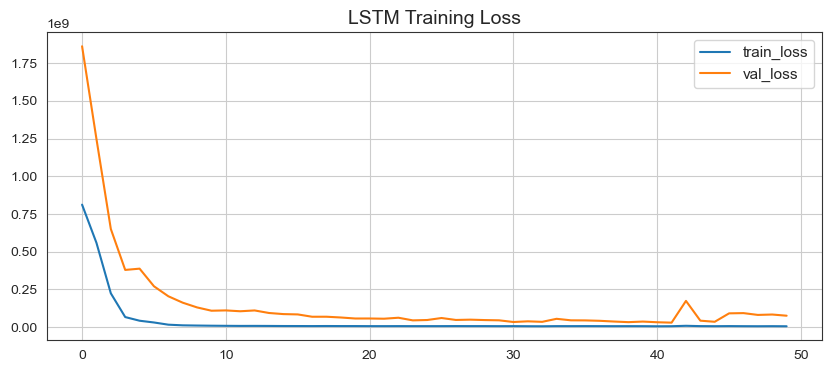

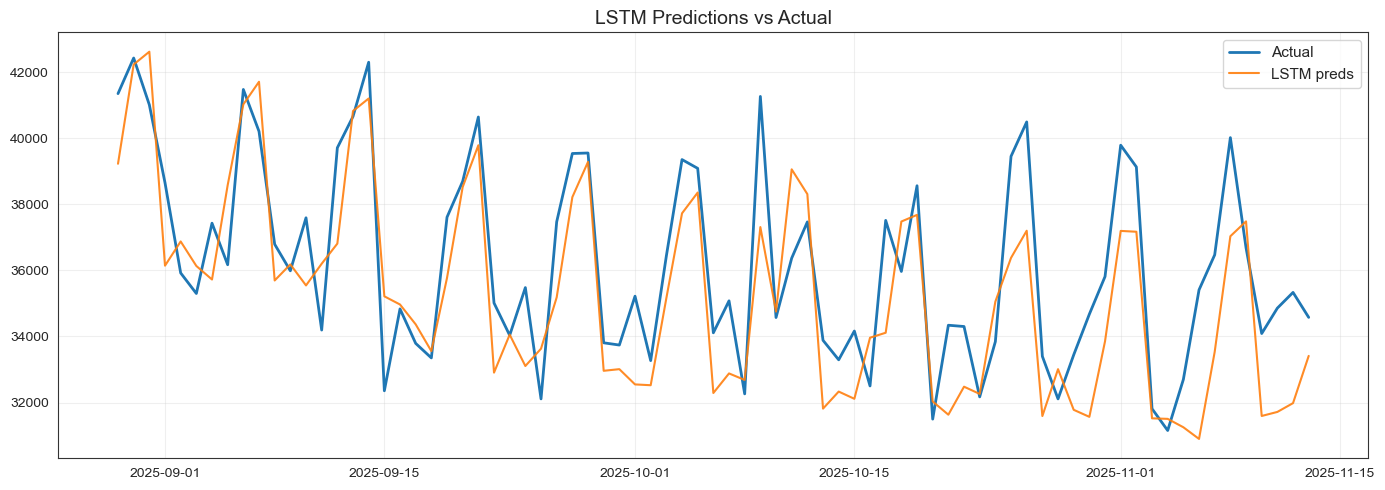

In [14]:
# Train LSTM on lag-based features to model sequential dependencies
# Reshape data to [samples, timesteps, features] for sequence input
# Include dropout and dense layers to capture non-linear patterns and prevent overfitting
# Use early stopping on validation loss
# Evaluate RMSE/MAE on test set and plot training loss and predictions
# Serves as a deep learning benchmark for temporal patterns beyond manual feature engineering



# Apply manually tuned best LSTM hyperparameters from previous Optuna search ran from another Notebook
timesteps = 14
units = 64
dropout = 0.19042775812762236
dense_units = 128
lr = 0.005186719698401007
batch_size = 16

# Prepare optimized DMatrix for XGBoost training
X_tr_final = np.array([X_train[i-timesteps+1:i+1] for i in range(timesteps-1, len(X_train))])
y_tr_final = y_train[timesteps-1:]
X_test_final = np.array([X_test[i-timesteps+1:i+1] for i in range(timesteps-1, len(X_test))])
y_test_aligned = y_test[timesteps-1:]  

# Build and train the model
model = Sequential([
    LSTM(units, input_shape=(X_tr_final.shape[1], X_tr_final.shape[2])),
    Dropout(dropout),
    Dense(dense_units, activation='relu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
hist = model.fit(
    X_tr_final, y_tr_final,
    validation_split=0.1,
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=0
)

# Predict and evaluate
lstm_preds = model.predict(X_test_final).squeeze()
lstm_scores = evaluate(y_test_aligned, lstm_preds, prefix="LSTM")
print("\nLSTM performance:", lstm_scores.round(3))

#  Plot training loss 
plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title("LSTM Training Loss")
plt.legend(); plt.show()

#  Plot predictions vs actual 
plt.figure(figsize=(14, 5))
plt.plot(test.index[-len(lstm_preds):], y_test_aligned, label='Actual', linewidth=2)
plt.plot(test.index[-len(lstm_preds):], lstm_preds, label='LSTM preds', alpha=0.9)
plt.title("LSTM Predictions vs Actual")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Ensemble components: ['naive', 'lr', 'rf', 'sarima', 'xgb', 'lstm']
Weights: {'naive': np.float64(0.102), 'lr': np.float64(0.207), 'rf': np.float64(0.17), 'sarima': np.float64(0.177), 'xgb': np.float64(0.171), 'lstm': np.float64(0.174)}
Ensemble scores: rmse    1701.914
mae     1373.821
Name: , dtype: float64


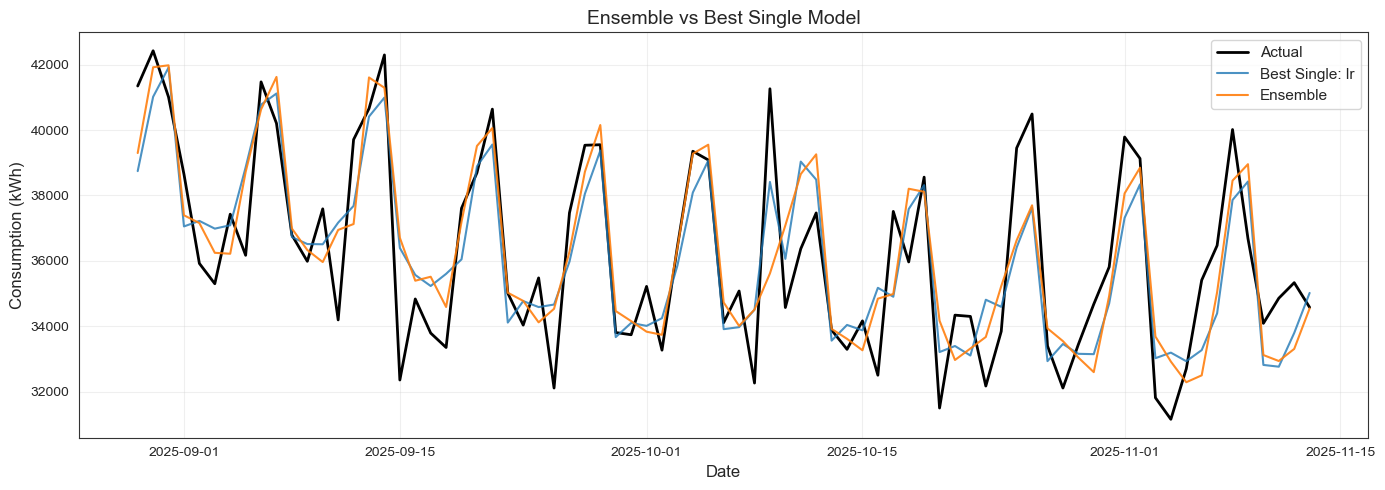

In [15]:
# Weighted ensemble of all available model predictions using inverse-RMSE
# Collect predictions and RMSEs from all models
# Compute normalized weights (lower RMSE → higher weight)
# Generate weighted forecast
# Evaluate ensemble (RMSE/MAE) and display weights
# Plot ensemble vs best single model



#Collect available model predictions and their RMSEs
available_preds = {}
available_scores = {}

# Model variables and their corresponding prediction arrays
model_vars = {
    'naive': 'naive_preds',
    'lr': 'lr_preds',
    'rf': 'rf_preds',
    'sarima': 'sarima_pred',
    'xgb': 'xgb_preds',
    'lstm': 'lstm_preds'
}

for name, var_name in model_vars.items():
    if var_name in globals():
        preds = globals()[var_name]
        score_name = f"{name}_scores" if name != 'naive' else "naive_scores"
        if score_name in globals():
            rmse_val = globals()[score_name]['rmse']
            available_preds[name] = preds
            available_scores[name] = rmse_val

if not available_preds:
    raise RuntimeError("No model predictions found — cannot build ensemble.")

# Align lengths of predictions and target
min_len = min([len(p) for p in available_preds.values()])
y_test_aligned = y_test[-min_len:]  # slice target to common length
for k in available_preds:
    available_preds[k] = np.array(available_preds[k][-min_len:])  # slice predictions

# Compute normalized weights using inverse RMSE 
names = list(available_preds.keys())
rmses = np.array([available_scores[n] for n in names], dtype=float)
inv_rmse = 1.0 / (rmses + 1e-8)  # prevent division by zero
weights = inv_rmse / inv_rmse.sum()

# Compute weighted ensemble prediction
ensemble_pred = np.zeros(min_len, dtype=float)
for w, n in zip(weights, names):
    ensemble_pred += w * available_preds[n]

# Evaluate ensemble
ensemble_scores = evaluate(y_test_aligned, ensemble_pred)
print("Ensemble components:", names)
print("Weights:", dict(zip(names, np.round(weights, 3))))
print("Ensemble scores:", ensemble_scores.round(3))

# Plot ensemble vs best single model
best_idx = np.argmin(rmses)
best_name = names[best_idx]

plt.figure(figsize=(14,5))
plt.plot(test.index[-min_len:], y_test_aligned, label='Actual', linewidth=2, color='black')
plt.plot(test.index[-min_len:], available_preds[best_name], label=f'Best Single: {best_name}', alpha=0.8)
plt.plot(test.index[-min_len:], ensemble_pred, label='Ensemble', alpha=0.9, color='tab:orange')
plt.title("Ensemble vs Best Single Model")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:

# Compile all model evaluations into a summary table
# Compute RMSE and MAE for each model and the ensemble
# Sort by RMSE and assign ranks
# Produce a formatted DataFrame for reporting
# Provides a quick overview of model performance


# Find the minimum length among all predictions (including ensemble)
min_len = min([len(p) for p in available_preds.values()] + [len(ensemble_pred)])
y_test_aligned = y_test[-min_len:]  # slice test target to match

# Slice all model predictions to the same length
aligned_preds = {name: np.array(pred[-min_len:]) for name, pred in available_preds.items()}
aligned_preds['ENSEMBLE'] = ensemble_pred[-min_len:]

# Collect results
results = []
for model_name, pred in aligned_preds.items():
    sc = evaluate(y_test_aligned, pred)  # same lengths now
    results.append({
        "Model": model_name.upper(),
        "RMSE": sc['rmse'],
        "MAE": sc['mae']
    })

# Build DataFrame
res_df = pd.DataFrame(results)

# Sort by RMSE ascending
res_df = res_df.sort_values("RMSE").reset_index(drop=True)

# Add rank
res_df['Rank'] = res_df['RMSE'].rank(method='min').astype(int)

# Add Accuracy (%) = 100 * (1 - (MAE / mean(|y|)))
baseline = np.mean(np.abs(y_test_aligned))
res_df["Accuracy (%)"] = 100 * (1 - (res_df["MAE"] / baseline))

# Display formatted table
res_df.style.format({
    "RMSE": "{:.2f}",
    "MAE": "{:.2f}",
    "Accuracy (%)": "{:.2f}"
}).set_properties(**{"text-align": "center"})




,Model,RMSE,MAE,Rank,Accuracy (%)
0,LR,1621.34,1358.74,1,96.25
1,ENSEMBLE,1701.91,1373.82,2,96.20
2,LSTM,1914.46,1604.62,3,95.57
3,SARIMA,1925.66,1553.68,4,95.71
4,XGB,1957.46,1565.22,5,95.68
5,RF,1995.03,1526.21,6,95.78
6,NAIVE,3392.03,2613.11,7,92.78


Best model: LR


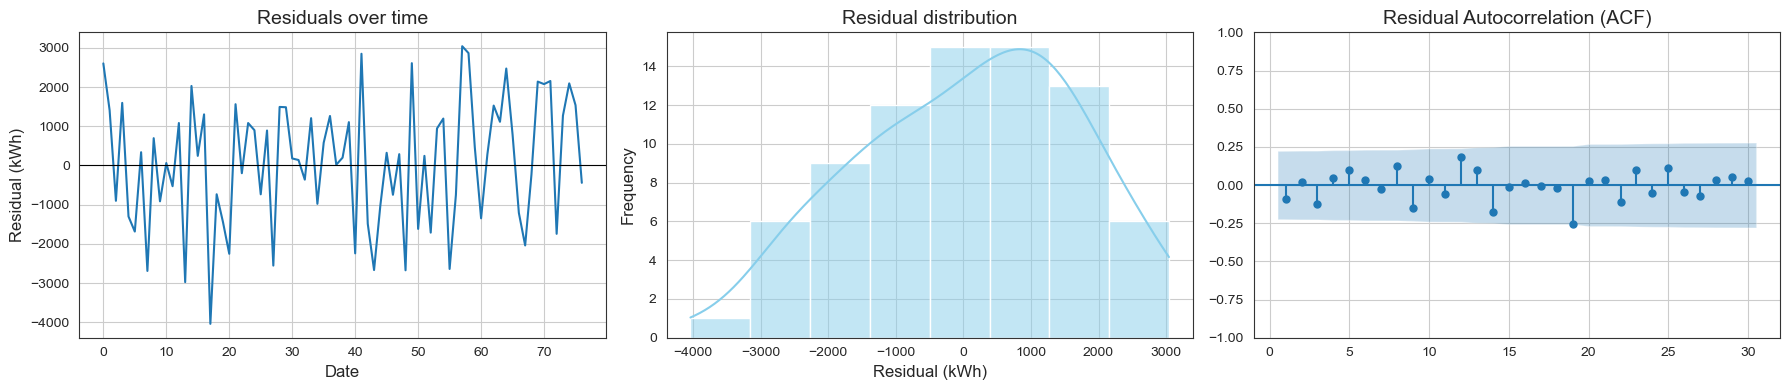

In [17]:
# Perform Residual diagnostics for the best model
# Plot residuals over time to check for patterns or drift
# Histogram + KDE to assess distribution and variance
# Autocorrelation (ACF) plot to detect remaining autocorrelation
# Confirms if residuals approximate random noise, validating model adequacy

from statsmodels.graphics.tsaplots import plot_acf

# Determine best model and get predictions
best = res_df.iloc[0]['Model']  
print("Best model:", best)

# Get predictions
best_preds = ensemble_pred if best.lower() == 'ensemble' else available_preds[best.lower()]

# prepare aligned y_test and predictions
min_len = min(len(y_test), len(best_preds))
y_test_aligned = y_test[-min_len:]
if isinstance(best_preds, np.ndarray):
    best_preds_aligned = best_preds[-min_len:]
else:
    best_preds_aligned = np.array(best_preds[-min_len:])

# Compute residuals
residuals = y_test_aligned - best_preds_aligned
residuals = pd.Series(residuals, index=y_test_aligned.index if hasattr(y_test_aligned, 'index') else range(len(residuals)))

# Plot residual diagnostics
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1. Residual time series
axes[0].plot(residuals.index, residuals)
axes[0].axhline(0, color='black', lw=0.8)
axes[0].set_title("Residuals over time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Residual (kWh)")

# 2. Residual histogram + KDE
sns.histplot(residuals, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title("Residual distribution")
axes[1].set_xlabel("Residual (kWh)")
axes[1].set_ylabel("Frequency")

# 3. Residual autocorrelation (ACF)
plot_acf(residuals, ax=axes[2], lags=30, zero=False)
axes[2].set_title("Residual Autocorrelation (ACF)")

plt.tight_layout()
plt.show()


In [ ]:
# Saves all trained models and test predictions for future use:
import os
import joblib

os.makedirs("saved_models", exist_ok=True)

# Save models
if 'lr' in globals():
    joblib.dump(lr, "saved_models/model_linear_reg.joblib")
if 'rf' in globals():
    joblib.dump(rf, "saved_models/model_rf.joblib")
if 'xgb_model' in globals():
    joblib.dump(xgb_model, "saved_models/model_xgb.joblib")
if 'sarima_res' in globals():
    try:
        joblib.dump(sarima_res, "saved_models/model_sarima.joblib")
    except Exception:
        import pickle
        with open("saved_models/model_sarima.pkl", "wb") as f:
            pickle.dump(sarima_res, f)

# Save LSTM model
if 'model' in globals() and tf is not None:
    model.save("saved_models/model_lstm.keras")

# Save predictions CSV
# Align predictions with test index
min_len = min([len(y_test)] + [len(v) for v in available_preds.values()])
pred_df = pd.DataFrame({"datetime": test.index[-min_len:], "actual": y_test[-min_len:]})

for k, v in available_preds.items():
    pred_df[f"pred_{k}"] = np.array(v)[-min_len:]

pred_df.to_csv("saved_models/predictions_test.csv", index=False)

print("✅ Saved models and predictions to 'saved_models/'")


✅ Saved models and predictions to 'saved_models/'


## Rationale for Model Selection

Algorithms were chosen to cover a spectrum from simple statistical models to advanced deep learning, enabling comparison of model complexity versus feature engineering in a data-limited setting.

**Baselines: Linear Regression & Random Forest**  
- *Linear Regression*: Interpretable baseline to test if engineered features can capture temporal dynamics linearly.  
- *Random Forest*: Non-linear ensemble to benchmark complex feature interactions with minimal tuning.  

**Classical Time-Series: SARIMAX**  
- Captures trend, seasonality, and autocorrelation; provides probabilistic forecasts for risk assessment.  

**Gradient Boosting: XGBoost**  
- Tests if a powerful non-linear method uncovers interactions missed by linear models; provides feature importance and handles heteroskedasticity.  

**Deep Learning: LSTM**  
- Evaluates the ability of recurrent networks to learn long-range temporal dependencies autonomously from engineered features.  

**Meta-Model: Weighted Ensemble**  
- Combines all models inversely weighted by RMSE to create a robust, stable forecast, leveraging complementary strengths.
